# GenBuilder: офлайн-эксперименты в ноутбуке

Этот ноутбук запускает пайплайн генерации на GeoJSON, выгруженных из UrbanAPI, без привязки к БД (через `blocks` параметр).

In [2]:
from __future__ import annotations

import os
import sys
import types
from pathlib import Path

PROJECT_ROOT = Path(r"G:\\Projects\\genbuilder_api")
INPUT_GEOJSON = Path("G:\\Рабочий стол\\ИТМО\\Аспирантура\\Эксперименты\\844_functional_zones.json")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)


PROJECT_ROOT: G:\Projects\genbuilder_api


In [3]:
"""Compatibility block.

В некоторых окружениях для GeoPandas/Shapely может не быть:
- geojson_pydantic
- shapely.validation.make_valid (на Shapely 1.7)
- shapely.errors.GEOSException (на Shapely 1.7)
- rtree/pygeos (нужны для пространственного индекса и gpd.sjoin)

Если у тебя всё это уже установлено в venv проекта, этот блок можно удалить.
"""

import shapely
import shapely.geometry as sg
import shapely.validation as sv
import shapely.errors as se

def _no_array_interface(self):
    raise AttributeError

for cls in [
    sg.Point, sg.LineString, sg.LinearRing, sg.Polygon,
    sg.MultiPoint, sg.MultiLineString, sg.MultiPolygon, sg.GeometryCollection,
]:
    try:
        cls.__array_interface__ = property(_no_array_interface)
    except Exception:
        pass

from shapely.geometry.base import BaseGeometry
def make_valid_fallback(geom: BaseGeometry):
    """Fallback for shapely.make_valid (not available in shapely 1.7): uses buffer(0)."""
    if geom is None:
        return geom
    try:
        if geom.is_valid:
            return geom
    except Exception:
        return geom
    try:
        fixed = geom.buffer(0)
        return fixed if fixed and not fixed.is_empty else geom
    except Exception:
        return geom

if not hasattr(sv, "make_valid"):
    sv.make_valid = make_valid_fallback

if not hasattr(se, "GEOSException"):
    se.GEOSException = se.ShapelyError

if "iduconfig" not in sys.modules:
    iduconfig = types.ModuleType("iduconfig")
    class Config(dict):
        """Minimal Config stub: reads values from environment variables."""
        def get(self, key, default=None):
            return os.environ.get(key, default)
    iduconfig.Config = Config
    sys.modules["iduconfig"] = iduconfig

if "app.schema.dto" not in sys.modules:
    dto_mod = types.ModuleType("app.schema.dto")
    class BlockFeatureCollection:
        """Lightweight substitute for GeoJSON Pydantic model in notebooks."""
        def __init__(self, fc: dict):
            self._fc = fc
        def model_dump(self):
            return self._fc
        @classmethod
        def model_validate(cls, obj):
            return cls(obj)
    dto_mod.BlockFeatureCollection = BlockFeatureCollection
    sys.modules["app.schema.dto"] = dto_mod

print("Shapely:", shapely.__version__)


Shapely: 2.1.2


In [4]:
"""Import GenBuilder orchestrator.

Если проект собран как приложение, можно импортировать готовый `builder`.
Он склеивает все зависимости и предоставляет `await builder.run(...)`.
"""

import nest_asyncio
nest_asyncio.apply()

import geopandas as gpd
import pandas as pd
import json
import time

from app.dependencies import builder

print("Builder:", type(builder))


Builder: <class 'app.logic.generation.Genbuilder'>


In [5]:
"""If rtree/pygeos are missing, GeoPandas spatial join will fail.

For experiments on small territories we can patch `gpd.sjoin` with a brute-force join.
If your environment has rtree/pygeos, you can skip this patch.
"""

import importlib.util

HAS_RTREE = importlib.util.find_spec("rtree") is not None
HAS_PYGEOS = importlib.util.find_spec("pygeos") is not None

print("HAS_RTREE:", HAS_RTREE, "HAS_PYGEOS:", HAS_PYGEOS)

if not (HAS_RTREE or HAS_PYGEOS):
    def sjoin_fallback(left: gpd.GeoDataFrame, right: gpd.GeoDataFrame, how="left", predicate="intersects"):
        """Brute-force spatial join fallback for small datasets (no rtree/pygeos)."""
        if how != "left" or predicate != "intersects":
            raise NotImplementedError("Fallback sjoin supports only how='left', predicate='intersects'")

        right_geoms = list(right.geometry)
        right_zone = list(right["zone"]) if "zone" in right.columns else [None] * len(right_geoms)

        zones = []
        index_right = []
        for geom in left.geometry:
            z = None
            j_idx = None
            if geom is not None and not geom.is_empty:
                for j, rgeom in enumerate(right_geoms):
                    if rgeom is None or rgeom.is_empty:
                        continue
                    if geom.intersects(rgeom):
                        z = right_zone[j]
                        j_idx = j
                        break
            zones.append(z)
            index_right.append(j_idx)

        out = left.copy()
        out["index_right"] = index_right
        out["zone"] = zones
        return out

    gpd.sjoin = sjoin_fallback
    print("Patched geopandas.sjoin with brute-force fallback")


HAS_RTREE: False HAS_PYGEOS: False
Patched geopandas.sjoin with brute-force fallback


In [6]:
"""Patch check_buildings_setbacks if it relies on spatial index.

В проде лучше держать rtree/pygeos и не трогать это.
"""

import app.logic.generation as genmod

def check_buildings_setbacks_noop(buildings_all, *args, **kwargs):
    """Notebook fallback: mark no setback violations."""
    if "broke_restriction_zone" not in buildings_all.columns:
        buildings_all["broke_restriction_zone"] = False
    return buildings_all

genmod.check_buildings_setbacks = check_buildings_setbacks_noop
print("Patched generation.check_buildings_setbacks")


Patched generation.check_buildings_setbacks


In [7]:
"""Load blocks GeoJSON and normalize properties.

Файл из UrbanAPI часто содержит nested-структуры. Здесь мы добавляем поле `zone`,
которое ожидает пайплайн (`residential`, `industrial`, `special`, `transport`, `business`, `unknown`).
"""
fc = json.loads(INPUT_GEOJSON.read_text(encoding="utf-8"))
features = fc.get("features", [])
print("Input features:", len(features))

def build_blocks_fc(features_subset):
    out = []
    for f in features_subset:
        props = f.get("properties", {}) or {}
        zone = (props.get("functional_zone_type") or {}).get("name") or props.get("zone") or "unknown"
        new_props = dict(props)
        new_props["zone"] = zone
        new_props["block_id"] = props.get("functional_zone_id")
        out.append({
            "type": "Feature",
            "properties": new_props,
            "geometry": f.get("geometry"),
        })
    return {"type": "FeatureCollection", "features": out}

blocks_fc = build_blocks_fc(features)

# Create DTO-like wrapper
from app.schema.dto import BlockFeatureCollection
blocks = BlockFeatureCollection(blocks_fc)


Input features: 119


In [8]:
"""Define targets.

Для residential входом удобнее задавать residents -> внутри он переводится в LA_target через la_per_person.
Для non-residential и mixed задаём coverage_area (полезная площадь) и среднюю этажность.
"""

targets_by_zone = {
    "residents": {"residential": 1500},
    "coverage_area": {
        "industrial": 20000,
        "special": 5000,
        "transport": 3000,
        "business": 10000,
        "unknown": 10000,
    },
    "default_floor_group": {
        "residential": "medium",
        "business": "high",
        "unknown": "high",
    },
    "density_scenario": {
        "residential": "min",
        "business": "min",
        "unknown": "min",
    },
    "floors_avg": {
        "industrial": 19,
        "special": 2,
        "transport": 1,
        "business": 7,
        "unknown": 7,
    },
}

generation_overrides = {
    "jobs_number": 1,
    "rectangle_finder_step": 5,
    "minimal_rectangle_side": 25,
}


In [9]:
"""Run generation for all blocks."""


t0 = time.time()
result_fc = await builder.run(
    targets_by_zone=targets_by_zone,
    blocks=blocks,
    scenario_id=None,
    generation_parameters_override=generation_overrides,
)
dt = time.time() - t0

print("Generated features:", len(result_fc.get("features", [])))
print("Runtime (s):", round(dt, 3))

OUT_PATH = Path("./buildings_result.geojson")
OUT_PATH.write_text(json.dumps(result_fc, ensure_ascii=False), encoding="utf-8")
print("Saved:", OUT_PATH.resolve())


02-08 22:35 | INFO     | Genbuilder.run: using blocks from request, count=119
02-08 22:35 | INFO     | Genbuilder.run: blocks split by zone: residential=27, mixed=15, non_residential=32, ignored=45
02-08 22:35 | INFO     | Genbuilder.run: converted residents to la_target using la_per_person=18.0, residents_by_zone={'residential': 1500}
02-08 22:35 | INFO     | Genbuilder.run: residential group -> blocks=27, la_target=27000.0, density_scenario=min, default_floor_group='medium'
02-08 22:35 | INFO     | Genbuilder.run: non-residential group -> blocks=32, coverage_by_zone={'industrial': 20000.0, 'transport': 3000.0, 'special': 5000.0}, total_coverage_target=28000.0, floors_avg_nonres={'industrial': 19.0, 'transport': 1.0, 'special': 2.0}
02-08 22:35 | INFO     | Genbuilder.run: mixed group (business+unknown) -> blocks=15, la_target=0.0, coverage_target=20000.0, density_scenario=min, default_floor_group='high', floors_avg_mixed={'business': 7.0, 'unknown': 7.0}
02-08 22:35 | WARNING  | Genb

Packing rectangles:   0%|          | 0/27 [00:00<?, ?it/s]

02-08 22:35 | INFO     | Genbuilder.run: residential generation finished, blocks=27, plots=80, buildings=72
02-08 22:35 | INFO     | Genbuilder.run: residential services not generated (missing normatives or buildings)
02-08 22:35 | INFO     | Genbuilder.run: starting non-residential generation pipeline


G:\Projects\genbuilder_api\app\logic\plots\plot_tuner.py:411: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby("src_index", group_keys=False).apply(


Packing rectangles:   0%|          | 0/32 [00:00<?, ?it/s]

02-08 22:35 | INFO     | Genbuilder.run: non-residential generation finished, blocks=32, plots=65, buildings=55
02-08 22:35 | INFO     | Genbuilder.run: starting mixed generation pipeline (business + unknown)


G:\Projects\genbuilder_api\app\logic\plots\plot_tuner.py:411: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby("src_index", group_keys=False).apply(


Packing rectangles:   0%|          | 0/15 [00:00<?, ?it/s]

02-08 22:35 | INFO     | Genbuilder.run: mixed generation finished, blocks=15, plots=0, buildings=0
02-08 22:35 | INFO     | Genbuilder.run: final zones distribution in buildings: residential=72, mixed=0, non_residential=55
02-08 22:35 | INFO     | Genbuilder.run: final buildings count=127, crs=EPSG:4326
Generated features: 127
Runtime (s): 8.075
Saved: G:\Projects\genbuilder_api\app\buildings_result.geojson


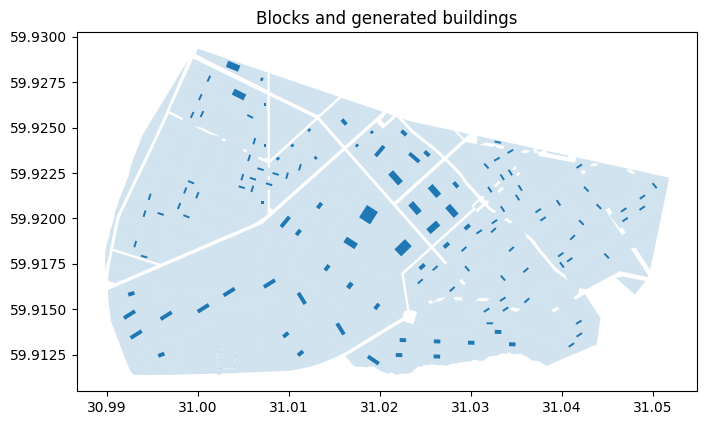

In [10]:
"""Quick visualization (matplotlib)."""

import matplotlib.pyplot as plt

gdf_buildings = gpd.GeoDataFrame.from_features(result_fc["features"], crs="EPSG:4326")
gdf_blocks = gpd.GeoDataFrame.from_features(blocks_fc["features"], crs="EPSG:4326")

ax = gdf_blocks.plot(figsize=(8, 8), alpha=0.2)
gdf_buildings.plot(ax=ax)
plt.title("Blocks and generated buildings")
plt.show()


In [11]:
"""Experiment harness: run on 1 block vs multiple blocks.

Собираем метрики: время, кол-во зданий, достигнутая жилая площадь, достигнутая полезная площадь,
доля нарушений.
"""

import random
from shapely.geometry import shape

from dataclasses import dataclass
from typing import Dict, Any, Optional
import geopandas as gpd

def _normalize_out(out):
    if hasattr(out, "model_dump"):
        return out.model_dump()
    if hasattr(out, "dict"):
        return out.dict()
    return out

def _extract_building_features(fc_out: dict) -> list[dict]:
    """
    Пытаемся найти geojson-фичи зданий в разных форматах ответа.
    Возвращаем список Feature-объектов.
    """
    if not isinstance(fc_out, dict):
        return []

    if isinstance(fc_out.get("features"), list):
        return fc_out["features"]

    b = fc_out.get("buildings")
    if isinstance(b, dict) and isinstance(b.get("features"), list):
        return b["features"]

    for k in ("result", "data", "geojson"):
        v = fc_out.get(k)
        if isinstance(v, dict) and isinstance(v.get("features"), list):
            return v["features"]

    return []

@dataclass(frozen=True)
class Targets:
    residents_by_zone: Dict[str, float]
    coverage_by_zone: Dict[str, float]
    la_per_person: float = 18.0

    @staticmethod
    def from_targets_by_zone(targets_by_zone: Dict[str, Any], la_per_person: float = 18.0) -> "Targets":
        return Targets(
            residents_by_zone=dict(targets_by_zone.get("residents", {}) or {}),
            coverage_by_zone=dict(targets_by_zone.get("coverage_area", {}) or {}),
            la_per_person=float(la_per_person),
        )

def compute_metrics(fc_out: dict, targets: dict, la_per_person: float = 18.0) -> dict:
    """
    Compute aggregated metrics from GenBuilder output GeoJSON (FeatureCollection of buildings).

    Notes:
    - living_area can be > 0 not only for 'residential', but also for mixed zones (e.g., 'business').
    - building_area is computed as footprint_area * floors_count in the pipeline.
    - functional_area is not present in the final response, so non-res area here is proxied by building_area.
    """
    features = (fc_out or {}).get("features") if isinstance(fc_out, dict) else None
    if not features:
        target_la = float(targets.get("residents", {}).get("residential", 0.0)) * float(la_per_person)
        target_nonres = float(
            sum((targets.get("coverage_area", {}) or {}).get(k, 0.0) for k in ["industrial", "special", "transport"])
        )
        return {
            "buildings": 0,
            "la_target": target_la,
            "la_actual": 0.0,
            "la_ratio": None if target_la <= 0 else 0.0,
            "nonres_target": target_nonres,
            "nonres_area_actual": 0.0,
            "nonres_ratio": None if target_nonres <= 0 else 0.0,
            "violations": 0,
            "violations_share": None,
            "services_buildings": 0,
        }

    gdf = gpd.GeoDataFrame.from_features(features)
    if "geometry" in gdf.columns and gdf.geometry.notna().any():
        gdf = gdf.set_crs("EPSG:4326", allow_override=True)

    if "living_area" not in gdf.columns:
        gdf["living_area"] = 0.0
    if "building_area" not in gdf.columns:
        gdf["building_area"] = 0.0
    if "broke_restriction_zone" not in gdf.columns:
        gdf["broke_restriction_zone"] = False
    if "zone" not in gdf.columns:
        gdf["zone"] = None
    if "service" not in gdf.columns:
        gdf["service"] = [[] for _ in range(len(gdf))]

    la_actual = float(gdf["living_area"].fillna(0.0).sum())

    nonres_mask = gdf["zone"].isin(["industrial", "special", "transport"])
    nonres_area_actual = float(gdf.loc[nonres_mask, "building_area"].fillna(0.0).sum())

    violations = int(gdf["broke_restriction_zone"].fillna(False).astype(bool).sum())
    violations_share = (violations / len(gdf)) if len(gdf) > 0 else None

    services_buildings = int(gdf["service"].apply(lambda x: isinstance(x, list) and len(x) > 0).sum())

    target_la = float(targets.get("residents", {}).get("residential", 0.0)) * float(la_per_person)
    target_nonres = float(
        sum((targets.get("coverage_area", {}) or {}).get(k, 0.0) for k in ["industrial", "special", "transport"])
    )

    return {
        "buildings": int(len(gdf)),
        "la_target": target_la,
        "la_actual": la_actual,
        "la_ratio": (la_actual / target_la) if target_la > 0 else None,
        "nonres_target": target_nonres,
        "nonres_area_actual": nonres_area_actual,
        "nonres_ratio": (nonres_area_actual / target_nonres) if target_nonres > 0 else None,
        "violations": violations,
        "violations_share": violations_share,
        "services_buildings": services_buildings,
    }

async def run_once(features_subset, targets, overrides):
    fc_in = build_blocks_fc(features_subset)
    blocks_local = BlockFeatureCollection(fc_in)

    t0 = time.time()
    out = await builder.run(
        targets_by_zone=targets,
        blocks=blocks_local,
        scenario_id=None,
        generation_parameters_override=overrides,
    )
    dt = time.time() - t0

    m = compute_metrics(out, targets)
    m["runtime_s"] = dt
    m["blocks"] = len(features_subset)
    return m


sizes = [1, 3, 5, 10]
sizes = [s for s in sizes if s <= len(features)]

rows = []
rng = random.Random(42)
for n in sizes:
    subset = rng.sample(features, n)
    rows.append(await run_once(subset, targets_by_zone, generation_overrides))

df = pd.DataFrame(rows)
df


02-08 22:35 | INFO     | Genbuilder.run: using blocks from request, count=1
02-08 22:35 | INFO     | Genbuilder.run: blocks split by zone: residential=0, mixed=0, non_residential=1, ignored=0
02-08 22:35 | INFO     | Genbuilder.run: converted residents to la_target using la_per_person=18.0, residents_by_zone={'residential': 1500}
02-08 22:35 | INFO     | Genbuilder.run: residential group -> blocks=0, la_target=27000.0, density_scenario=min, default_floor_group='medium'
02-08 22:35 | INFO     | Genbuilder.run: non-residential group -> blocks=1, coverage_by_zone={'industrial': 20000.0, 'transport': 3000.0, 'special': 5000.0}, total_coverage_target=28000.0, floors_avg_nonres={'industrial': 19.0, 'transport': 1.0, 'special': 2.0}
02-08 22:35 | INFO     | Genbuilder.run: mixed group (business+unknown) -> blocks=0, la_target=0.0, coverage_target=20000.0, density_scenario=min, default_floor_group='high', floors_avg_mixed={'business': 7.0, 'unknown': 7.0}
02-08 22:35 | WARNING  | Genbuilder.ru

Packing rectangles:   0%|          | 0/1 [00:00<?, ?it/s]

02-08 22:35 | INFO     | Genbuilder.run: non-residential generation finished, blocks=1, plots=5, buildings=4
02-08 22:35 | INFO     | Genbuilder.run: mixed generation skipped (no blocks or both targets are 0)
02-08 22:35 | INFO     | Genbuilder.run: final zones distribution in buildings: residential=0, mixed=0, non_residential=4
02-08 22:35 | INFO     | Genbuilder.run: final buildings count=4, crs=EPSG:4326
02-08 22:35 | INFO     | Genbuilder.run: using blocks from request, count=3
02-08 22:35 | INFO     | Genbuilder.run: blocks split by zone: residential=0, mixed=0, non_residential=1, ignored=2
02-08 22:35 | INFO     | Genbuilder.run: converted residents to la_target using la_per_person=18.0, residents_by_zone={'residential': 1500}
02-08 22:35 | INFO     | Genbuilder.run: residential group -> blocks=0, la_target=27000.0, density_scenario=min, default_floor_group='medium'
02-08 22:35 | INFO     | Genbuilder.run: non-residential group -> blocks=1, coverage_by_zone={'industrial': 20000.0

G:\Projects\genbuilder_api\app\logic\plots\plot_tuner.py:411: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby("src_index", group_keys=False).apply(


Packing rectangles:   0%|          | 0/1 [00:00<?, ?it/s]

02-08 22:35 | INFO     | Genbuilder.run: non-residential generation finished, blocks=1, plots=1, buildings=1
02-08 22:35 | INFO     | Genbuilder.run: mixed generation skipped (no blocks or both targets are 0)
02-08 22:35 | INFO     | Genbuilder.run: final zones distribution in buildings: residential=0, mixed=0, non_residential=1
02-08 22:35 | INFO     | Genbuilder.run: final buildings count=1, crs=EPSG:4326
02-08 22:35 | INFO     | Genbuilder.run: using blocks from request, count=5


G:\Projects\genbuilder_api\app\logic\plots\plot_tuner.py:411: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby("src_index", group_keys=False).apply(


02-08 22:35 | INFO     | Genbuilder.run: blocks split by zone: residential=3, mixed=0, non_residential=0, ignored=2
02-08 22:35 | INFO     | Genbuilder.run: converted residents to la_target using la_per_person=18.0, residents_by_zone={'residential': 1500}
02-08 22:35 | INFO     | Genbuilder.run: residential group -> blocks=3, la_target=27000.0, density_scenario=min, default_floor_group='medium'
02-08 22:35 | INFO     | Genbuilder.run: non-residential group -> blocks=0, coverage_by_zone={'industrial': 20000.0, 'transport': 3000.0, 'special': 5000.0}, total_coverage_target=28000.0, floors_avg_nonres={'industrial': 19.0, 'transport': 1.0, 'special': 2.0}
02-08 22:35 | INFO     | Genbuilder.run: mixed group (business+unknown) -> blocks=0, la_target=0.0, coverage_target=20000.0, density_scenario=min, default_floor_group='high', floors_avg_mixed={'business': 7.0, 'unknown': 7.0}
02-08 22:35 | WARNING  | Genbuilder.run: scenario_id is None, service normatives are not loaded
02-08 22:35 | INFO

Packing rectangles:   0%|          | 0/3 [00:00<?, ?it/s]

02-08 22:35 | INFO     | Genbuilder.run: residential generation finished, blocks=3, plots=8, buildings=6
02-08 22:35 | INFO     | Genbuilder.run: residential services not generated (missing normatives or buildings)
02-08 22:35 | INFO     | Genbuilder.run: non-residential generation skipped (no blocks or coverage_target <= 0)
02-08 22:35 | INFO     | Genbuilder.run: mixed generation skipped (no blocks or both targets are 0)
02-08 22:35 | INFO     | Genbuilder.run: final zones distribution in buildings: residential=6, mixed=0, non_residential=0
02-08 22:35 | INFO     | Genbuilder.run: final buildings count=6, crs=EPSG:4326
02-08 22:35 | INFO     | Genbuilder.run: using blocks from request, count=10
02-08 22:35 | INFO     | Genbuilder.run: blocks split by zone: residential=1, mixed=2, non_residential=2, ignored=5
02-08 22:35 | INFO     | Genbuilder.run: converted residents to la_target using la_per_person=18.0, residents_by_zone={'residential': 1500}
02-08 22:35 | INFO     | Genbuilder.ru

G:\Projects\genbuilder_api\app\logic\plots\plot_tuner.py:411: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby("src_index", group_keys=False).apply(


Packing rectangles:   0%|          | 0/1 [00:00<?, ?it/s]

02-08 22:35 | INFO     | Genbuilder.run: residential generation finished, blocks=1, plots=5, buildings=5
02-08 22:35 | INFO     | Genbuilder.run: residential services not generated (missing normatives or buildings)
02-08 22:35 | INFO     | Genbuilder.run: starting non-residential generation pipeline


G:\Projects\genbuilder_api\app\logic\plots\plot_tuner.py:411: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby("src_index", group_keys=False).apply(


Packing rectangles:   0%|          | 0/2 [00:00<?, ?it/s]

02-08 22:35 | INFO     | Genbuilder.run: non-residential generation finished, blocks=2, plots=2, buildings=2
02-08 22:35 | INFO     | Genbuilder.run: starting mixed generation pipeline (business + unknown)


G:\Projects\genbuilder_api\app\logic\plots\plot_tuner.py:411: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf = gdf.groupby("src_index", group_keys=False).apply(


Packing rectangles:   0%|          | 0/2 [00:00<?, ?it/s]

02-08 22:35 | INFO     | Genbuilder.run: mixed generation finished, blocks=2, plots=0, buildings=0
02-08 22:35 | INFO     | Genbuilder.run: final zones distribution in buildings: residential=5, mixed=0, non_residential=2
02-08 22:35 | INFO     | Genbuilder.run: final buildings count=7, crs=EPSG:4326


,buildings,la_target,la_actual,la_ratio,nonres_target,nonres_area_actual,nonres_ratio,violations,violations_share,services_buildings,runtime_s,blocks
0,4,27000.0,0.0,0.000000,28000.0,9960.0,0.355714,0,0.0,0,0.179705,1
1,1,27000.0,0.0,0.000000,28000.0,12480.0,0.445714,0,0.0,0,0.141349,3
2,6,27000.0,19719.0,0.730333,28000.0,0.0,0.000000,0,0.0,0,0.418155,5
3,7,27000.0,27000.0,1.000000,28000.0,48880.0,1.745714,0,0.0,0,0.751527,10
